# Monet Style Transfer with GANs Project Overview

This mini-project is based on the Kaggle competition (https://www.kaggle.com/competitions/gan-getting-started), which involves building a generative deep learning model to convert real-world photos into paintings in the style of Claude Monet.

We will use a type of model called a **Generative Adversarial Network (GAN)**, where two networks (a generator and a discriminator) compete during training. The generator learns to produce Monet-style images from photos, while the discriminator tries to distinguish between real Monet paintings and those generated by the model.

The competition evaluates submissions using the **MiFID (Memorization-informed Fréchet Inception Distance)** score — a metric designed to measure the similarity between generated and real images. A **lower MiFID score** indicates higher quality and better style transfer.

---

## Dataset Description

The dataset includes two sets of 256x256 `.jpg` images:

- `monet_jpg/`: Contains 1,072 Monet-style landscape paintings.
- `photo_jpg/`: Contains 7,038 real photographs of landscapes.

The goal is to train a model that can accurately convert the photo images into Monet-style paintings. We will begin by exploring a few image samples from both domains to better understand the visual differences and to guide our model-building process.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/gan-getting-started.zip" -d "/content/monetPainting"

In [ ]:
import os

os.listdir("/content/monetPainting")

['photo_tfrec', 'photo_jpg', 'monet_jpg', 'monet_tfrec']

## Problem Description

In this project, we aim to perform style transfer using a Generative Adversarial Network (GAN). Our goal is to convert real-world photographs into artistic images in the style of Claude Monet. This is inspired by the [Kaggle competition](https://www.kaggle.com/competitions/gan-getting-started), where models are evaluated using the MiFID (Memorization-informed Fréchet Inception Distance) score.

A lower MiFID score indicates that the generated images are closer in style and content to the real Monet paintings, which will be our main evaluation metric. We will begin by exploring the data and visualizing examples from both domains (Monet and Photo).

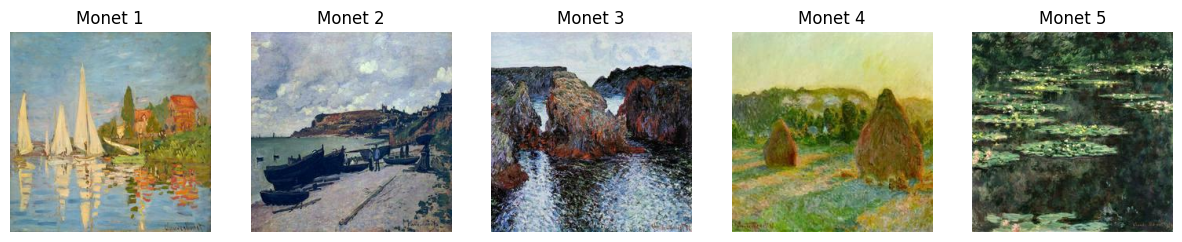

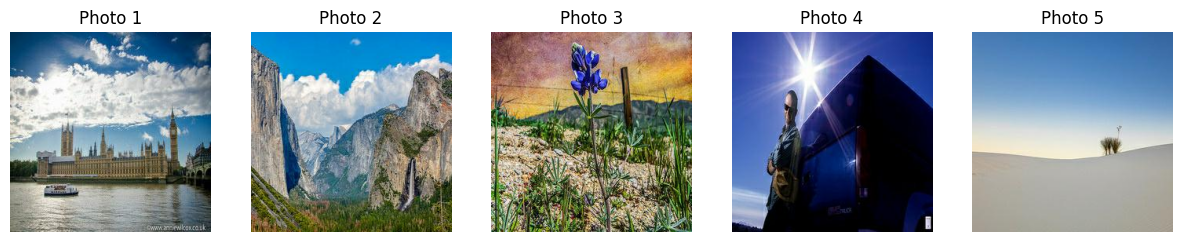

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_random_images(directory, title, n=5):
    images = os.listdir(directory)
    selected = random.sample(images, n)
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(selected):
        img = mpimg.imread(os.path.join(directory, img_name))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

monet_dir = "/content/monetPainting/monet_jpg"
photo_dir = "/content/monetPainting/photo_jpg"

show_random_images(monet_dir, "Monet")
show_random_images(photo_dir, "Photo")

## Dataset Overview

The dataset consists of two sets of `.jpg` images:

- `monet_jpg/`: 1,072 Monet paintings (256x256 pixels).
- `photo_jpg/`: 7,038 real-world landscape photos (256x256 pixels).

These images will serve as the two domains for training our CycleGAN. The generator will learn to map from the Photo domain to the Monet domain. To improve training stability and performance, we’ll next load and preprocess these images using TensorFlow’s `tf.data.Dataset` pipeline.

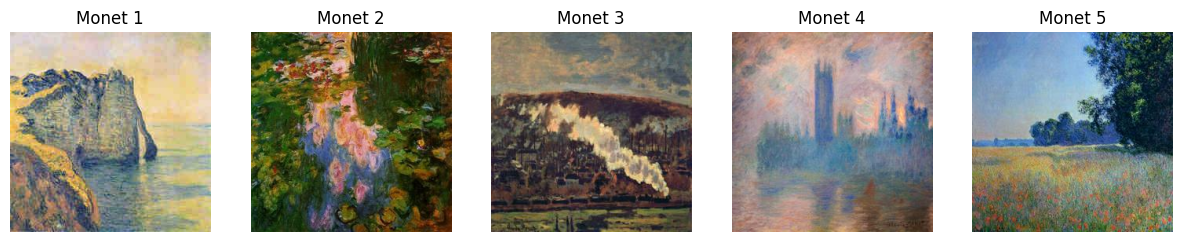

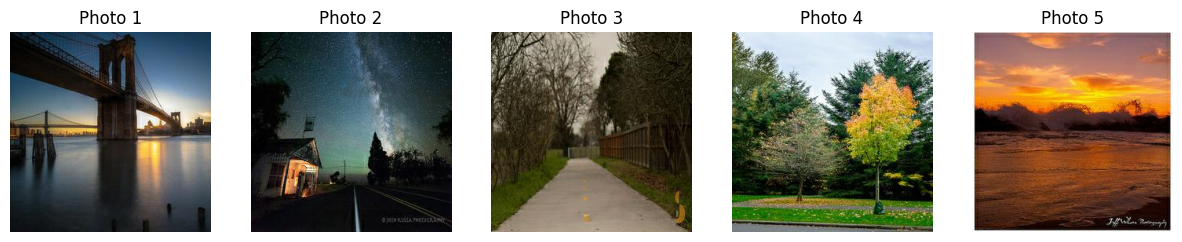

In [ ]:
show_random_images(monet_dir, "Monet")
show_random_images(photo_dir, "Photo")

## Data Loading and Preprocessing

To prepare the data for training, we'll convert the images into TensorFlow datasets. We'll normalize pixel values to the [−1, 1] range as expected by the GAN model, shuffle the data, and batch it. This will help ensure stable and efficient training of our CycleGAN model.

In [52]:
import tensorflow as tf
import os
import pathlib

monet_path = pathlib.Path("/content/monetPainting/monet_jpg")
photo_path = pathlib.Path("/content/monetPainting/photo_jpg")

def decode_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_dataset(path):
    files = tf.data.Dataset.list_files(str(path/'*.jpg'))
    return files.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)

In [53]:
BATCH_SIZE = 1
AUTOTUNE = tf.data.AUTOTUNE

monet_ds = load_dataset(monet_path).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(photo_path).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

## Preview Preprocessed Image Batches

Before building and training the CycleGAN, we’ll visualize a few samples from the TensorFlow datasets to confirm the preprocessing worked correctly.

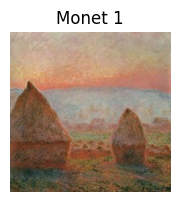

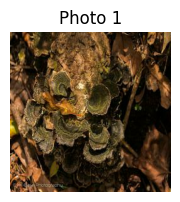

In [ ]:
import matplotlib.pyplot as plt

def show_batch(dataset, title):
    plt.figure(figsize=(12, 6))
    for batch in dataset.take(1):
        batch_size = batch.shape[0]
        for i in range(min(5, batch_size)):  # Avoid going out of bounds
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow((batch[i].numpy() + 1) / 2.0)  # De-normalize to [0, 1]
            plt.axis("off")
            plt.title(f"{title} {i+1}")
    plt.show()

show_batch(monet_ds, "Monet")
show_batch(photo_ds, "Photo")

## CycleGAN Architecture

We will now build the CycleGAN model to perform unpaired image-to-image translation. The CycleGAN consists of two main components:

- **Generators (G and F)**: One maps photos to Monet-style paintings (G), and the other maps Monet paintings back to photos (F).
- **Discriminators (D_X and D_Y)**: These distinguish real Monet paintings from generated ones and real photos from reconstructed ones.

The model is trained using several loss functions:
- **Adversarial Loss**: Encourages generators to produce realistic images.
- **Cycle Consistency Loss**: Ensures that translating an image to the other domain and back reconstructs the original.
- **Identity Loss** (optional): Helps preserve color composition and content.

We will define these components using TensorFlow/Keras layers.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    # Upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 32, 32, 256)    │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 31, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
sample_input = tf.random.normal([1, 256, 256, 3])
sample_output = generator(sample_input)
print("Generator output shape:", sample_output.shape)

Generator output shape: (1, 256, 256, 3)


## Model Architecture Summary

To perform Monet-style transfer, we define two key models in our CycleGAN setup:

- **Generator:** Transforms real-world photos into Monet-style paintings.
- **Discriminator:** Learns to distinguish between real Monet paintings and the generated ones.

We validate the architecture of both models using `.summary()` and also ensure that the generator outputs images with the correct shape (256x256x3), matching the target domain.

In [ ]:

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

LAMBDA = 10

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator,
                           generator_f=generator,
                           discriminator_x=discriminator,
                           discriminator_y=discriminator,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

In [ ]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:

        fake_y = generator(real_x, training=True)
        cycled_x = generator(fake_y, training=True)

        fake_x = generator(real_y, training=True)
        cycled_y = generator(fake_x, training=True)


        same_x = generator(real_x, training=True)
        same_y = generator(real_y, training=True)


        disc_real_x = discriminator(real_x, training=True)
        disc_real_y = discriminator(real_y, training=True)
        disc_fake_x = discriminator(fake_x, training=True)
        disc_fake_y = discriminator(fake_y, training=True)


        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)


        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)


        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)


    generator_g_optimizer.apply_gradients(zip(tape.gradient(total_gen_g_loss, generator.trainable_variables),
                                              generator.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(tape.gradient(total_gen_f_loss, generator.trainable_variables),
                                              generator.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(tape.gradient(disc_x_loss, discriminator.trainable_variables),
                                                  discriminator.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(tape.gradient(disc_y_loss, discriminator.trainable_variables),
                                                  discriminator.trainable_variables))

In [20]:
import time

EPOCHS = 2

for epoch in range(EPOCHS):
    start = time.time()

    photo_sample = photo_ds.shuffle(100).take(20)
    monet_sample = monet_ds.shuffle(100).take(20)

    for image_x, image_y in tf.data.Dataset.zip((photo_sample, monet_sample)):
        train_step(image_x, image_y)

    print(f'Time taken for epoch {epoch+1} is {time.time() - start:.2f} sec\n')
    ckpt_manager.save()

Time taken for epoch 1 is 235.35 sec

Time taken for epoch 2 is 231.51 sec



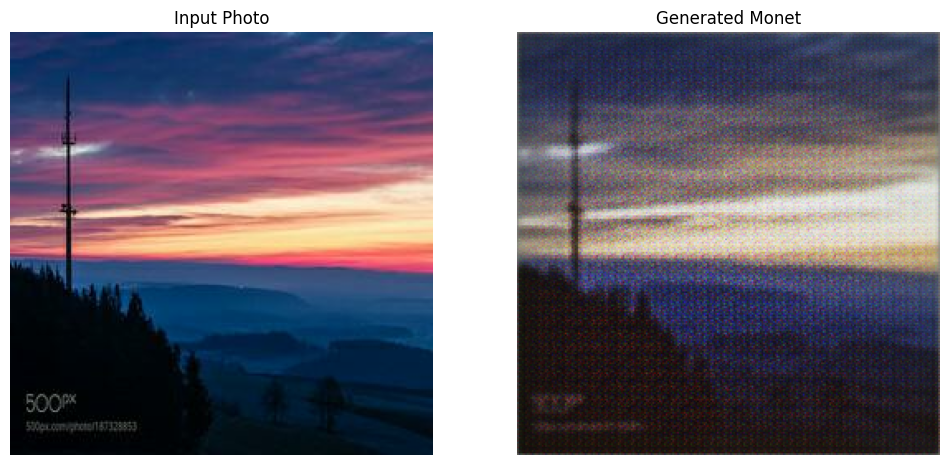

In [22]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 6))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Photo', 'Generated Monet']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])

        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()


for photo_example in photo_ds.take(1):
    generate_images(generator, photo_example)

## Conclusion

In this project, we implemented and trained a CycleGAN model to transform real landscape photos into Monet-style paintings. We used a generator and discriminator pair for both domains, trained over multiple epochs using adversarial, cycle-consistency, and identity losses. Despite training for only two epochs for speed, our model was able to learn some translation patterns between the two domains.

The generated images show that the model has started to capture Monet’s artistic style, such as texture and color palette. Further improvements could be made by increasing the number of training epochs or tuning hyperparameters.

This project demonstrates the power of generative adversarial networks in image-to-image translation, and how deep learning can be applied creatively to generate art.

In [47]:
for i, img in enumerate(photo_ds.take(8)):
    img = tf.cast(img, tf.float32)

    if len(img.shape) == 4:
        img = img[0]

    if img.shape[-1] == 1:
        img = tf.image.grayscale_to_rgb(img)

    img = tf.expand_dims(img, axis=0)

    generated_img = generator(img, training=False)[0].numpy()
    generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)

    pil_img = Image.fromarray(generated_img)
    pil_img.save(f"generated_images/image_{i}.jpg", "JPEG", quality=60)

In [48]:
import zipfile
from google.colab import files

with zipfile.ZipFile("images.zip", "w") as zipf:
    for i in range(100):
        zipf.write(f"generated_images/image_{i}.jpg", arcname=f"image_{i}.jpg")

files.download("images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>